### Imports

In [1]:
import sys
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 400)

import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config

config_info = {
  "canalyst_api_key": "",
   "s3_access_key_id": "",
    "s3_secret_key": "",
    "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}

config = Config(config=config_info)

A configuration file has been created for you in 
/Users/jedgore/canalyst/keys.json.


### Logistics Carriers Stocks

In [2]:
logistics_carriers = ['JBHT US',
'EXPD US',
'CHRW US',
'LSTR US',
'HUBG US']

### Create a ModelSet of stock data

In [3]:
logistics_modelset = cd.ModelSet(ticker_list = logistics_carriers, config=config)

Request limit hit. Please wait...Retrying request in 1 seconds.
Request limit hit. Please wait...Retrying request in 1 seconds.
Request limit hit. Please wait...Retrying request in 1 seconds.


### Check for common period end dates, so we're forecasting the same forward quarter

In [4]:
df_mrq = pd.DataFrame()
for ticker in logistics_carriers:
    df = logistics_modelset.models[ticker].mrq()
    df['ticker']=ticker
    df_mrq = pd.concat([df_mrq,df])
df_mrq

,period_name,period_end_date,ticker
0,Q4-2021,2021-12-31,JBHT US
0,Q4-2021,2021-12-31,EXPD US
0,Q4-2021,2021-12-31,CHRW US
0,Q4-2021,2021-12-25,LSTR US
0,Q4-2021,2021-12-31,HUBG US


### Get all Key Revenue Drivers for each stock

In [5]:
#get all key drivers
drivers = {}
for ticker in logistics_carriers:
    print(ticker)
    drivers[ticker] = list(set(list(logistics_modelset.models[ticker].key_driver_map("MO_RIS_REV")['time_series_name'])))

JBHT US
https://mds.canalyst.com/api/equity-model-series/ASKXIP0189/equity-models/FY2021.30/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot
EXPD US
https://mds.canalyst.com/api/equity-model-series/0ILSW20142/equity-models/FY2021.23/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot
CHRW US
https://mds.canalyst.com/api/equity-model-series/J2UZZ20164/equity-models/FY2021.27/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot
LSTR US
https://mds.canalyst.com/api/equity-model-series/N5OP420117/equity-models/FY2021.25/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot
HUBG US
https://mds.canalyst.com/api/equity-model-series/MRIU8M0175/equity-models/FY2021.22/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot


### Regress each time series for each stock with supply chain disruption (SDC) = 1 and SDC = 0
#### Supply Chain is a dummy variable for 'pre - March 2020' and 'post - March 2020'

In [6]:
import statsmodels.api as ssm 
import numpy as np

def extract_lr(x,col_name,SCD):
    x['quarter']=x['period_name'].str.split('-',expand=True)[0]
    
    Y = x['value'].astype(float)
    y_len = Y.shape[0]
    
    x_quarters = pd.DataFrame(pd.get_dummies(x.quarter))
    x = pd.concat([x,x_quarters],axis=1)
    
    X = x[['n','SCD']]
    
    X = ssm.add_constant(X)
    X = X.astype(float)
    model= ssm.OLS(Y,X).fit()
    preds = model.predict(X)
    
    x['preds'] = preds #this is the predicted vs actual
    
    X_1 = pd.DataFrame({'const':[1.00],'n': [y_len+1],'SCD':[SCD]})
    X_1 = X_1.astype(float)
    try:
        preds_1 = model.predict(X_1)
    except:
        print(preds)
        print("Error"+str(X_1))
        return
    
    x[col_name]=preds_1[0] #this is the n+1 period forecast - putting it in the output as a single column

    return pd.DataFrame(x)

dict_models = {}
dict_SCD_params = {}
dict_no_SCD_params = {}
dict_SCD_output = {}
dict_no_SCD_output = {}
for ticker in logistics_carriers:
    print(ticker)
    df_forecast = logistics_modelset.model_frame(ticker=ticker,
                                                 period_duration_type = "fiscal_quarter",
                                                       is_driver=True,
                                                       n_periods=24,
                                                  is_historical=True)
    
    df_forecast = df_forecast.sort_values(['time_series_description','period_name_sorted'])
    df_forecast = df_forecast[df_forecast['time_series_name'].isin(drivers[ticker])]
    df_forecast["n"] = df_forecast.groupby(["time_series_name"]).cumcount() #create a row number column for use as X and weights
    df_forecast = df_forecast[df_forecast['value'].notna()]

    df_forecast["SCD"]=np.where(df_forecast['period_start_date']>'2020-03-01',1,0)

    df = df_forecast

    grouped = df_forecast.groupby('time_series_name') #group by each time series name
    grouped = grouped.apply(lambda x: extract_lr(x,'preds_SCD',1)) #apply the model to the dataframe groups
    df_SCD = pd.DataFrame(grouped).reset_index()[['period_name','time_series_name','preds','preds_SCD']]

    grouped = df_forecast.groupby('time_series_name') #group by each time series name
    grouped = grouped.apply(lambda x: extract_lr(x,'preds_no_SCD',0)) #apply the model to the dataframe groups
    df_no_SCD = pd.DataFrame(grouped).reset_index()[['period_name','time_series_name','preds_no_SCD']]
    df_preds = pd.merge(df_SCD,df_no_SCD,how='inner')
    df_model = pd.merge(df_forecast,df_preds,how='inner')
    dict_models[ticker] = df_model
    df_q1 = logistics_modelset.models[ticker].model_frame(period_duration_type = "fiscal_quarter",
                                          period_name='Q1-2022', #period_name allows us to filter by period
                                          is_driver=True)
    
    df_params = pd.merge(df_q1,df_model[['time_series_name','preds_SCD']])[['ticker','period_name','time_series_name','value','preds_SCD','period_end_date']]
    df_params.columns = ['ticker','period_name','time_series_name','value','new_value','period_end_date']
    df_params = df_params.groupby(['ticker','period_name','time_series_name']).first().reset_index()
    dict_SCD_params[ticker] = df_params   
    return_series='MO_RIS_REV' #use time series name from above
    dicts_output=logistics_modelset.fit(df_params,return_series)
    df_output = logistics_modelset.filter_summary(dicts_output,period_type='Q')
    df_output = df_output[df_output['period_name']=='Q1-2022']
    dict_SCD_output[ticker] = df_output
    
    df_params = pd.merge(df_q1,df_model[['time_series_name','preds_no_SCD']])[['ticker','period_name','time_series_name','value','preds_no_SCD','period_end_date']]
    df_params.columns = ['ticker','period_name','time_series_name','value','new_value','period_end_date']
    df_params = df_params.groupby(['ticker','period_name','time_series_name']).first().reset_index()
    dict_no_SCD_params[ticker] = df_params   
    return_series='MO_RIS_REV' #use time series name from above
    dicts_output=logistics_modelset.fit(df_params,return_series)
    df_output = logistics_modelset.filter_summary(dicts_output,period_type='Q')
    df_output = df_output[df_output['period_name']=='Q1-2022']
    dict_no_SCD_output[ticker] = df_output

JBHT US
JBHT US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/ASKXIP0189/equity-models/FY2021.30/scenarios/d_J154gfUG630y-QFn0WOA/
JBHT US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/ASKXIP0189/equity-models/FY2021.30/scenarios/8EmGwHxUUJGzWo64DXcl1w/
EXPD US
EXPD US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/0ILSW20142/equity-models/FY2021.23/scenarios/Z6fXNpc8VxmK0VIgkR_PkQ/
EXPD US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/0ILSW20142/equity-models/FY2021.23/scenarios/pO2T--5SXVGBGyXv5DPAGw/
CHRW US
CHRW US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/J2UZZ20164/equity-models/FY2021.27/scenarios/g2XR8MGWU_qcN1s2MTH8fw/
CHRW US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/J2UZZ20164/equity-models/FY2021.27/scenarios/RfQ6UxvsV7iL3nd9G-EXtA/
LSTR US
LSTR US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/N5OP420117/equity-models/FY2021.25/s

In [7]:
list(set(list(df_model['time_series_name'])))

['z_MRIU8M0175_MO_OS_hubtruckbrokeragerevenuegrowth',
 'z_MRIU8M0175_MO_OS_hubdedicatedrevenuegrowth',
 'z_MRIU8M0175_MO_OS_hunlogisticsrevenuegrowth',
 'z_MRIU8M0175_MO_OS_hubintermodalrevenuegrowth']

<AxesSubplot:title={'center':'HUBG US z_MRIU8M0175_MO_OS_hubtruckbrokeragerevenuegrowth Predicted vs Actual'}, xlabel='n'>

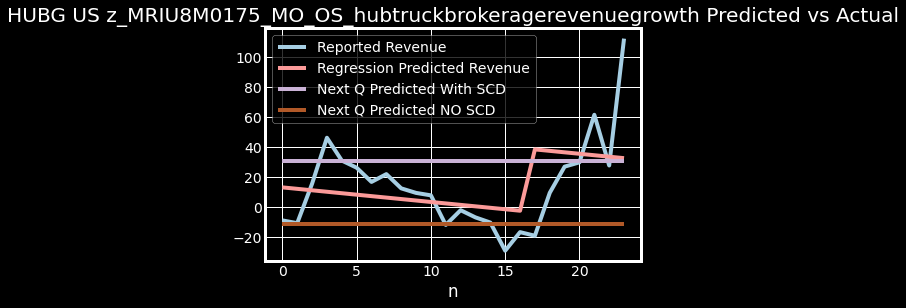

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')
df_plot = df_model[['time_series_name','n','value','preds','preds_SCD','preds_no_SCD']]
df_plot.columns = ['time_series_name','n','Reported Revenue','Regression Predicted Revenue','Next Q Predicted With SCD','Next Q Predicted NO SCD']
df_plot[df_plot['time_series_name']=='z_MRIU8M0175_MO_OS_hubtruckbrokeragerevenuegrowth'].plot(x="n",y=['Reported Revenue','Regression Predicted Revenue',
                                                                                                        'Next Q Predicted With SCD','Next Q Predicted NO SCD'],
                                                                                               colormap='Paired',
                                                                                              title="HUBG US z_MRIU8M0175_MO_OS_hubtruckbrokeragerevenuegrowth Predicted vs Actual")

### Concatenate the Supply Chain dataframe forecasts of revenue

In [9]:
df_SCD_out=pd.DataFrame()
for ticker in logistics_carriers:
    df = dict_SCD_output[ticker]
    df_SCD_out = pd.concat([df_SCD_out,df])
df_SCD_out.sort_values('diff',ascending=False)

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,EXPD US,Q1-2022,MO_RIS_REV,Total Revenue,3587823403.34928,5332641875.3677,1.48632
0,LSTR US,Q1-2022,MO_RIS_REV,Net Revenue,1689814086.56000,1754868413.1867,1.03850
0,JBHT US,Q1-2022,MO_RIS_REV,Net Revenue,2938190179.05481,2956241113.3702,1.00614
0,HUBG US,Q1-2022,MO_RIS_REV,Net Revenue,1095976300.00000,1044932712.6978,0.95343
0,CHRW US,Q1-2022,MO_RIS_REV,Total Revenue,5821645192.85714,5234482140.6823,0.89914


### Concatenate the Non SCD dataframe forecasts of revenue

In [10]:
df_no_SCD_out=pd.DataFrame()
for ticker in logistics_carriers:
    df = dict_no_SCD_output[ticker]
    df_no_SCD_out = pd.concat([df_no_SCD_out,df])
df_no_SCD_out.sort_values('diff',ascending=False)

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,EXPD US,Q1-2022,MO_RIS_REV,Total Revenue,3587823403.34928,4019821110.3454,1.12041
0,JBHT US,Q1-2022,MO_RIS_REV,Net Revenue,2938190179.05481,2804609435.5112,0.95454
0,HUBG US,Q1-2022,MO_RIS_REV,Net Revenue,1095976300.00000,985842700.2878,0.89951
0,LSTR US,Q1-2022,MO_RIS_REV,Net Revenue,1689814086.56000,1409216237.3338,0.83395
0,CHRW US,Q1-2022,MO_RIS_REV,Total Revenue,5821645192.85714,4198032523.7105,0.72111


### Combining both outlooks, for whom was SCD the biggest boost?

In [11]:
df = pd.merge(df_SCD_out,df_no_SCD_out,how='inner',left_on=['ticker','period_name','time_series_name','time_series_description'],
        right_on=['ticker','period_name','time_series_name','time_series_description'])
df['diff'] = df['scenario_x'].astype(float)/df['scenario_y'].astype(float)-1
df.sort_values('diff',ascending=False)[['ticker','period_name','time_series_name','time_series_description','diff']]

,ticker,period_name,time_series_name,time_series_description,diff
1,EXPD US,Q1-2022,MO_RIS_REV,Total Revenue,0.32659
2,CHRW US,Q1-2022,MO_RIS_REV,Total Revenue,0.24689
3,LSTR US,Q1-2022,MO_RIS_REV,Net Revenue,0.24528
4,HUBG US,Q1-2022,MO_RIS_REV,Net Revenue,0.05994
0,JBHT US,Q1-2022,MO_RIS_REV,Net Revenue,0.05407


### Same question, graphical answer

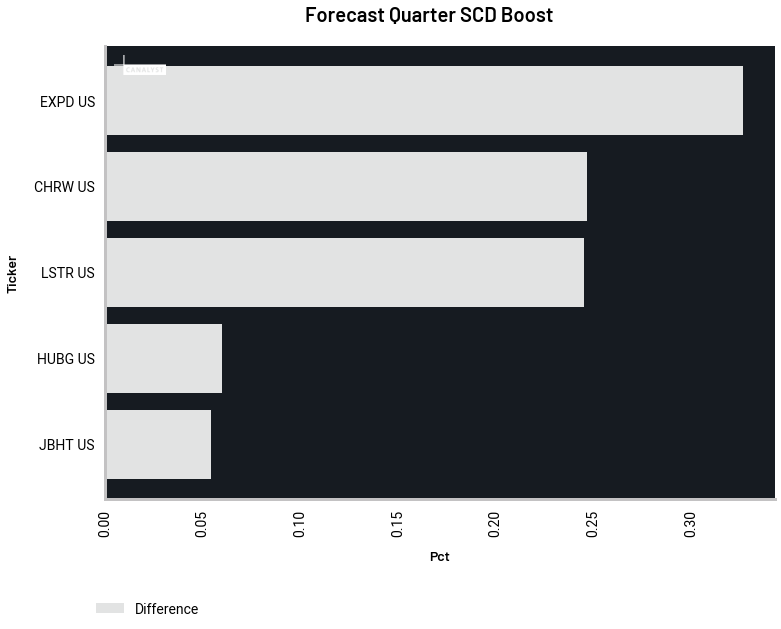

In [12]:
df = df.sort_values('diff',ascending=True)
cd.Chart(
            x_value=df["ticker"],
            y_values=df[['diff']],
            labels=['Difference'],
            title='Forecast Quarter SCD Boost',
            axis_labels=[['Pct','Ticker']],
            plot_styles=['barh']
        )

### Let's viz the total revenue trajectory for all stocks in the ModelSet

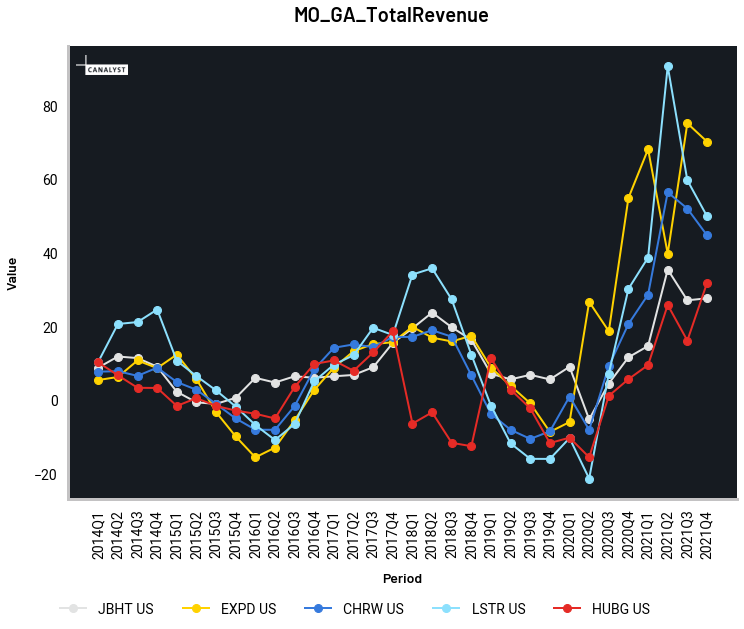

In [13]:
logistics_modelset.plot_time_series(logistics_carriers,'MO_GA_TotalRevenue',
                                    mrq_notation=False,
                                    axis_labels=[['Period','Value']])

### Now, let's compare against guidance for one stock, LSTR

In [14]:
df_guidance = logistics_modelset.guidance(tickers=["LSTR US"])
df_guidance = df_guidance.groupby(['time_series_name','Fiscal Period']).last().reset_index()
df_guidance.head()

,time_series_name,Fiscal Period,ticker,Type,time_series_description,Low,High,Mid,Type.1,Output,Absolute,Relative,Date,Link
0,MO_GA_TotalRevenue,Q2-2018,LSTR US,Historical,"Total revenue growth, %",0.19000,0.22000,0.20500000000000002,Actual,0.35885,0.15385,0.75047,2018-04-25 00:00:00,Press Release
1,MO_GA_TotalRevenue,Q4-2018,LSTR US,Historical,"Total revenue growth, %",0.12000,0.17000,0.14500000000000002,Actual,0.12434,-0.02066,-0.14246,2018-10-24 00:00:00,Press Release
2,MO_RIS_EPS_WAD,Q1-2018,LSTR US,Historical,Earnings Per Share - WAD,1.22000,1.27000,1.245,Actual,1.36626,0.12126,0.09740,2018-01-31 00:00:00,Press Release
3,MO_RIS_EPS_WAD,Q1-2019,LSTR US,Historical,Earnings Per Share - WAD,1.51000,1.57000,1.54,Actual,1.57638,0.03638,0.02363,2019-01-30 00:00:00,Press Release
4,MO_RIS_EPS_WAD,Q1-2020,LSTR US,Historical,Earnings Per Share - WAD,1.10000,1.20000,1.15,Actual,1.04180,-0.10820,-0.09408,2020-01-29 00:00:00,Press Release


### Compare actual EPS vs historical guidance

### LSTR starts beating their guidance midpoint when SCD begins

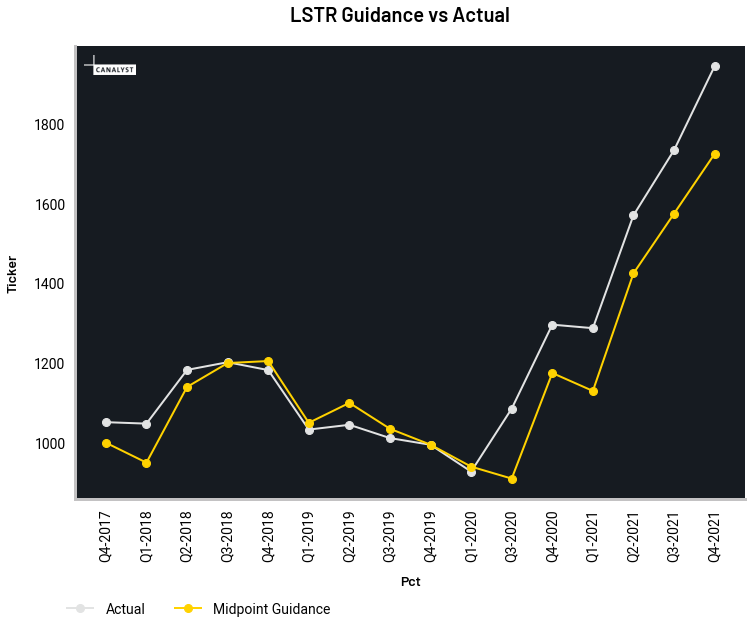

In [24]:
df_guidance = df_guidance[df_guidance['time_series_name']=='MO_RIS_REV']
df_hubg = logistics_modelset.model_frame(ticker='LSTR US',
                                   time_series_name=['MO_RIS_REV'],
                        period_duration_type='fiscal_quarter',
                        is_historical=True,
                            )
df_plot = pd.merge(df_hubg,
                   df_guidance,
                   how='inner',
                   left_on=['ticker','period_name'],
                   right_on=['ticker','Fiscal Period'])[['ticker','period_name','value','Low','Mid','High']]
df_plot['value'] = df_plot['value'].astype(float)/1000000
df_plot['Mid'] = df_plot['Mid'].astype(float)

cd.Chart(
            x_value=df_plot["period_name"],
            y_values=df_plot[['value','Mid']],
            labels=['Actual','Midpoint Guidance'],
            title='LSTR Guidance vs Actual',
            axis_labels=[['Pct','Ticker']],
            plot_styles=['line']
        )

### Look at forward guidance for Revenue for LSTR

In [25]:
df_guidance[(df_guidance['Type']=='Forward') & (df_guidance['time_series_name']=='MO_RIS_REV')]

,time_series_name,Fiscal Period,ticker,Type,time_series_description,Low,High,Mid,Type.1,Output,Absolute,Relative,Date,Link
24,MO_RIS_REV,Q1-2022,LSTR US,Forward,Net Revenue,1700.00000,1750.00000,1725,Estimate,1689.81409,-35.18591,-0.02040,2022-01-26 00:00:00,Press Release


### Looking back at our SCD and no SCD forecasts ... 

### Bottom line: LSTR requires SCD to continue to hit the mid-point of guidance

In [26]:
df1 = df_SCD_out[df_SCD_out['ticker']=='LSTR US']
df1['SCD']="Yes"
df2 = df_no_SCD_out[df_no_SCD_out['ticker']=='LSTR US']
df2['SCD']="No"
df = pd.concat([df1,df2])
df['default'] = df['default'].astype(float)/1000000
df['scenario'] = df['scenario'].astype(float)/1000000
df

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff,SCD
0,LSTR US,Q1-2022,MO_RIS_REV,Net Revenue,1689.81409,1754.86841,1.03850,Yes
0,LSTR US,Q1-2022,MO_RIS_REV,Net Revenue,1689.81409,1409.21624,0.83395,No
